In [1]:
#Importing Pandas
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

#Importing libraries for Regression
import statsmodels.api as sm
from patsy import dmatrices

Populating the interactive namespace from numpy and matplotlib


### Q1: Read in data

We see cases of turks rating urls with the same category multiple times. This is probably a crowdsourcing technique wherein turks are sent the same url to verify their credentials. We follow this assumption and do not drop these duplicates. 

We print the first 10 rows of gold and labels DataFrames.

In [2]:
#Creating gold DataFrame from gold.txt
gold = pd.read_csv('gold.txt', delimiter = '\t', header = None)
gold.columns = ['url', 'category']
print("gold DataFrame First 10 rows: ")
gold[:10]

gold DataFrame First 10 rows: 


,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X
5,http://3x-pix.com,X
6,http://4d.com,G
7,http://4neurons.com,G
8,http://4-panama-city-beach-condo.com/index.htm,G
9,http://4whw.8m.net/,X


In [3]:
#Creating labels DataFrame from labels.txt
labels = pd.read_csv('labels.txt', delimiter = '\t', header = None)
labels.columns = ['turk', 'url', 'category']
print("labels DataFrame First 10 rows: ")
labels[:10]

labels DataFrame First 10 rows: 


,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
6,A31Z3E5SLATLML,http://000.cc,P
7,AAVCPZ8WTCFVK,http://000.cc,G
8,AHY98D5P05XIV,http://000.cc,G
9,APTFS1S88K5VC,http://000.cc,G


### Q2: Split into two DataFrames

In [4]:
#Creating labels_on_gold DataFrame
labels_on_gold = labels[labels['url'].isin(gold['url'])]
print('Row Count of labels_on_gold: ', len(labels_on_gold))

#Creating labels_unknown DataFrame
labels_unknown = labels[~labels['url'].isin(gold['url'])]
print('Row Count of labels_unknown: ', len(labels_unknown))

Row Count of labels_on_gold:  3324
Row Count of labels_unknown:  89397


### Q3: Compute accuracies of turks

In [5]:
#Merging with the original gold DataFrame to check for Rating Correctness
labels_temp = labels_on_gold.merge(gold,
                                   left_on = 'url',
                                   right_on = 'url',
                                   suffixes = ['_labels', '_gold'])

#Checking for Rating Correctness
labels_temp['accuracy'] = (labels_temp['category_labels'] == labels_temp['category_gold'])

#Grouping by turk and calculating the aggregation columns
labels_temp = labels_temp.groupby('turk')['accuracy'].agg(['count','mean'])

#Renaming the aggregation columns and storing result in rater_goodness DataFrame
rater_goodness = labels_temp.rename(columns = {'count':'number_of_ratings', 'mean':'average_correctness_of_ratings'})
rater_goodness

,number_of_ratings,average_correctness_of_ratings
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
...,...,...
AYWOBMTEGFVVI,1,0.000000
AZ1S5BIG5R6P6,35,0.714286
AZSDW7JJL5VA7,100,0.680000


### Q4: Odds ratios

In [6]:
#Creating the odds column
rater_goodness['odds'] = (rater_goodness['average_correctness_of_ratings'] / (1.001 - rater_goodness['average_correctness_of_ratings']))
rater_goodness

,number_of_ratings,average_correctness_of_ratings,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


### Q5: Most accurate turks

In [7]:
#Sorting the rater_goodness DataFrame by average correctness and storing the top 10
top_10_accurate_turks = rater_goodness[rater_goodness['number_of_ratings'] >= 20].sort_values(by = 'average_correctness_of_ratings', ascending = False)[:10]
top_10_accurate_turks

,number_of_ratings,average_correctness_of_ratings,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


In [8]:
#Printing the Top 10 Accurate Turks
print('\033[1m' + 'The top 10 accurate Turks are: ' + '\033[0m')
for i in range(0, len(top_10_accurate_turks.index.values)):
    print (top_10_accurate_turks.index.values[i])

The top 10 accurate Turks are: 
A2U0R4X38GUKZE
A22C0PJUBFJTI0
A23YQUBXZPKILZ
ATVALOQVDCMZW
A1HIXWH4OXT8S4
A3220HG1O83HQ4
A32W20KGQXS0LL
A20PWAB7G3HDHU
AJSJVK40F5HM6
A31OCN4MNHUQ6W


### Q6: Rating counts versus accuracy

In [9]:
#Setting up Linear Regression Model
y, X = dmatrices('number_of_ratings ~ average_correctness_of_ratings', data=rater_goodness, return_type='dataframe')

model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_ratings   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Tue, 03 Aug 2021   Prob (F-statistic):              0.459
Time:                        23:13:16   Log-Likelihood:                -1232.3
No. Observations:                 269   AIC:                             2469.
Df Residuals:                     267   BIC:                             2476.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         10.3317      3.092      3.341      0.001       4.244      16.420
average_correctness_of_ratings     3.1096      4.197      0.741      0.459      -5.155      11.374
==============================================================================
Omnibus:                      236.177   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3693.030
Skew:                           3.634   Prob(JB):                         0.00
Kurtosis:                      19.633   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The P Value for Accuracy is very high (0.463) which indicates that it is not statistically significant, i.e. we cannot reject the null hypothesis at 95% confidence interval. This shows that the number of ratings is not related to the accuracy. This is further verified by the low R-squared value, which shows lack of variance fit as well. 

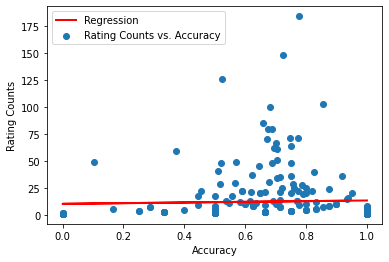

In [10]:
x = rater_goodness['average_correctness_of_ratings']
y_actual = rater_goodness['number_of_ratings']
y_expected = result.params['Intercept'] + result.params['average_correctness_of_ratings'] * x

#Plotting Scatter Plot with Linear Regression fit
scatter(x=x, y=y_actual, label='Rating Counts vs. Accuracy')
plot(x, y_expected, color='red', linewidth=2, label='Regression')
xlabel('Accuracy')
ylabel('Rating Counts')
legend(loc='best')

We can further see from the above Linear Regression fit that there is no fixed relationship between Rating Counts and Accuracy.

We now move forward with checking the data with the qcut function to further confirm our analysis. 

### Q7: Overall predicted odds

In [11]:
#Creating DataFrame of Reliable Turks
reliable_turks = rater_goodness[rater_goodness['number_of_ratings'] > rater_goodness['number_of_ratings'].quantile(0.75)]

#Creating Merged DataFrame between labels_unknown and rater_goodness on turk
labels_unknown_merged = labels_unknown.merge(reliable_turks,
                                             left_on = 'turk',
                                             right_on = 'turk',
                                             suffixes = ['_labels_unknown', '_reliable_turks'])

#Dropping Duplicates

labels_unknown_merged = labels_unknown_merged.sort_values(['url','category'])

# # #Grouping By url and category to get product of odds for turks above 75%
odds_product_75_turks = labels_unknown_merged.groupby(['url', 'category'])['odds'].agg(['prod'])
odds_product_75_turks = odds_product_75_turks.rename(columns = {'prod':'overall odds'})
odds_product_75_turks

overall odds
url                         category              
http://0-101.net            G             2.155963
http://000.cc               G             1.460583
http://0000.jp              G            14.488244
http://000relationships.com G             5.681060
                            P             1.851852
...                                            ...
http://zynga.com            G             3.704611
http://zz868.com            G             1.047852
                            P             1.851852
http://zzx.cc               G             1.330229
                            X             1.620746

[13983 rows x 1 columns]

### Q8: Predicted categories

In [12]:
#Using idxmax() for Top Categories and max() for Top Odds on the Transposed Table
odds_product_75_turks = odds_product_75_turks.unstack('category')
top_categories = pd.DataFrame(odds_product_75_turks.T.idxmax())
top_odds = pd.DataFrame(odds_product_75_turks.T.max())
result_75 = top_categories.merge(top_odds,
                                 on = 'url',
                                 suffixes = ['_categories', '_odds'])

#Renaming the columns to top category and top odds and displaying the correct values
result_75 = result_75.rename(columns = {'0_categories':'top category', '0_odds':'top odds'})
result_75['top category'] = result_75['top category'].apply(lambda x:x[-1])
print('\033[1m' + 'result_75' + '\033[0m')
result_75

result_75


,top category,top odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
...,...,...
http://zwinky.com,G,16.141443
http://zylom.com,G,1.735526
http://zynga.com,G,3.704611


### Q9: Predicted categories using more turks

We first show the result_25 table and then display the cross table.

In [13]:
#Repeating Q7 and Q8 for turks above 25%

#Creating DataFrame of Reliable Turks
reliable_turks = rater_goodness[rater_goodness['number_of_ratings'] > rater_goodness['number_of_ratings'].quantile(0.25)]

#Creating Merged DataFrame between labels_unknown and rater_goodness on turk
labels_unknown_merged_2 = labels_unknown.merge(reliable_turks,
                                               left_on = 'turk',
                                               right_on = 'turk',
                                               suffixes = ['_labels_unknown', '_reliable_turks'])

#Dropping Duplicates
labels_unknown_merged_2 = labels_unknown_merged_2.sort_values(['url','category'])

#Grouping By url and category to get product of odds for turks above 25%
odds_product_25_turks = labels_unknown_merged_2.groupby(['url', 'category'])['odds'].agg(['prod'])
odds_product_25_turks = odds_product_25_turks.rename(columns = {'prod':'overall odds'}).unstack('category')
odds_product_25_turks

#Using idxmax() for Top Categories and max() for Top Odds on the Transposed Table
top_categories = pd.DataFrame(odds_product_25_turks.T.idxmax())
top_odds = pd.DataFrame(odds_product_25_turks.T.max())
result_25 = top_categories.merge(top_odds,
                                 on = 'url',
                                 suffixes = ['_categories', '_odds'])

#Renaming the columns to top category and top odds and displaying the correct values
result_25 = result_25.rename(columns = {'0_categories':'top category', '0_odds':'top odds'})

result_25['top category'] = result_25['top category'].apply(lambda x:x[-1])
print('\033[1m' + 'result_25' + '\033[0m')
result_25

result_25


,top category,top odds
url,,
http://0-101.net,G,2.155963e+00
http://000.cc,G,2.181050e+03
http://0000.jp,G,2.877556e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.014149e+00
...,...,...
http://zwinky.com,P,1.000000e+03
http://zylom.com,G,2.873345e+03
http://zynga.com,G,5.442125e+01


In [14]:
#Comparing result_75 and result_25

pd.crosstab(result_75.rename(columns = {'top category':'top category (result_75)'})['top category (result_75)'], result_25.rename(columns = {'top category':'top category (result_25)'})['top category (result_25)'])

top category (result_25),G,P,R,X
top category (result_75),,,,
G,8327,574,186,216
P,189,328,47,19
R,21,34,128,25
X,27,6,26,457


**The most errors are present at the prediction of G by result_75 and the prediction of P by result_25 (574 errors). We know that the result_75 values indicate more confidence in the turks, and hence we trust their prediction of G more.**